In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-laq6ce60 because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [3]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
# actually this is all points, not just start points
start_points = all_points[:,:,1:].reshape(-1,7)
print("start_points_shape", start_points.shape)
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
#start_points = start_points[:,3:]
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 155 pickup attempts
start_points_shape (9920, 7)
std of:  0.17859106200728153
shape before reducing dimension (155, 64, 8)
dataset variance of: [0.00082463 0.00106736 0.00316102 0.00634536 0.0256     0.00564557
 0.00894256]


In [4]:
dataset = start_points
dataset

array([[ 5.30630546e-02, -7.39897730e-02,  6.99848376e-02, ...,
         5.77279855e-02,  3.91912119e-02,  2.56211944e-02],
       [ 4.82265267e-02, -6.74389532e-02,  6.44204345e-02, ...,
         5.95007100e-02,  3.93298113e-02,  2.38431718e-02],
       [ 4.42146147e-02, -6.03095820e-02,  5.96689720e-02, ...,
         6.08009003e-02,  3.93789762e-02,  2.20194015e-02],
       ...,
       [-9.03704476e-03,  1.13378370e-01,  8.72505381e-02, ...,
        -7.04652473e-02, -2.69143945e-02, -1.99310649e-01],
       [-2.72879079e-03,  1.19000039e-01,  1.06496165e-01, ...,
        -9.01796312e-02, -2.89765200e-02, -2.14355879e-01],
       [-1.67703832e-05,  1.42264068e-01,  1.38627073e-01, ...,
        -1.05488737e-01, -2.73580771e-02, -2.35037893e-01]])

In [5]:
np.random.seed(1)
train_indices = np.random.choice(len(dataset),200,replace=False)
test_indices = [i for i in range(len(dataset)) if i not in train_indices]
train_dataset=dataset[train_indices]
test_dataset=dataset[test_indices]
print(train_dataset.shape,test_dataset.shape)

(200, 7) (9720, 7)


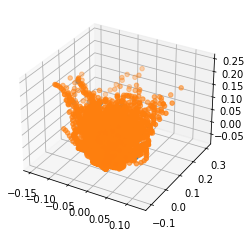

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(train_dataset[:,0],train_dataset[:,1],train_dataset[:,2]);
ax.scatter(test_dataset[:,0],test_dataset[:,1],test_dataset[:,2]);

In [7]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.scatter(train_dataset[:,3],train_dataset[:,4],train_dataset[:,5]);
#ax.scatter(test_dataset[:,3],test_dataset[:,4],test_dataset[:,5]);

## 2D VAE Fit to Dataset

In [8]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [9]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
  

In [10]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [11]:
def error(vae, dataset):
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float).to(device),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float).to(device)
                       )[0].detach().cpu().numpy()
    recons = vae.decode(torch.tensor(embeds,dtype=torch.float).to(device),
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float).to(device))[0].detach().cpu()
    rmse = np.sqrt(np.mean(np.sum(np.square(dataset - recons.numpy()),axis=1)))
    return rmse

In [12]:
# train a CurvVAE model with given beta and gamma and return
# the string name of the saved model
def train_vae_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset,device="cpu"):
    vae = make_vae(latent_dim=latentdim).to(device)
    num_epochs = epochs
    epsilon_scale_start = 0.5
    epsilon_scale = epsilon_scale_start
    savedir  = f'{testname}lat{latentdim}_lr{lr}_gamma{gamma}_es{epsilon_scale_start}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    print(savedir)
    train_loader = Loader(train_dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
        log_dir=savedir, lr=lr, annealingBatches=0, record_loss_every=200, loss_func = "gaussian")
    epoch = 0
    traintesterrors = []
    for _ in range(num_epochs*3):
        epoch+=1
        # up num sample points to reduce variance of curvature measure
        embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=gamma, epsilon_scale = epsilon_scale, num_new_samp_points=512)
        is_error = embst[0]
        if is_error:
            raise Exception
        if epoch % 10 == 0:
            traintesterrors.append((epoch,error(vae,train_dataset),error(vae,test_dataset)))
    sm.save_fcpassthrough_vae(vae, savedir)
    print(savedir)
    return savedir,traintesterrors

In [13]:
test_dataset.shape

(9720, 7)

In [ ]:
testname = "overfitting/allposes"
all_models=[]
all_traintesterrors = []
for run in range(10):
    for lr in [0.00005,0.0001,0.00001]:
        for beta,gamma in [[0.00001, 0.001  ],
                           [0.00001, 0.00001],
                           [0.001, 0],
                           [0.00001, 0],
                           [0.00001, 0.00005],
                           [0.00001, 0.0001 ],
                           [0.00001, 0.0002 ],
                           [0.00001, 0.0003 ],
                           [0.00001, 0.0005 ],
                           [0.00001, 0.0007 ],
                           [0.00001, 0.0008 ],
                           [0.00001, 0.0009 ],
                           [0.00001, 0.002  ],
                           [0.00001, 0.004  ],
                           [0.00001, 0.01  ],
                           [0.00001, 0.1  ],
                           [0.00001, 0],
                           [0.0001, 0],
                           [0.002, 0],
                           [0.003, 0],
                           [0.005, 0],
                           [0.007, 0],
                           [0.01  , 0],
                           [0.02  , 0],
                           [0.04  , 0],
                           [0.1  , 0],
                           [1.0    , 0],
                           [0.00001, 1.  ],
                           [0.00001, 10.  ]
                          ]:
            secreg = 0
            latentdim = 3
            epochs=800
            savedir,traintesterrors = train_vae_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset,device=device)
            print(np.array(traintesterrors)[-10:,])
            all_models.append((beta,gamma,latentdim,lr,savedir))
            all_traintesterrors.append(traintesterrors)
    np.savez(f'200samples_inprogress_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', all_models=all_models,all_traintesterrors=all_traintesterrors)

overfitting/allposeslat3_lr5e-05_gamma0.001_es0.5_beta1e-05_20220719-152407
overfitting/allposeslat3_lr5e-05_gamma0.001_es0.5_beta1e-05_20220719-152407
[[2.31000000e+03 6.87285292e-02 7.11666378e-02]
 [2.32000000e+03 6.76245056e-02 6.91837338e-02]
 [2.33000000e+03 6.82691721e-02 6.94530358e-02]
 [2.34000000e+03 6.85006149e-02 7.01495858e-02]
 [2.35000000e+03 6.73189645e-02 6.87685975e-02]
 [2.36000000e+03 6.84055843e-02 6.89611240e-02]
 [2.37000000e+03 6.84678535e-02 6.95738915e-02]
 [2.38000000e+03 6.76142621e-02 6.89653601e-02]
 [2.39000000e+03 6.77949599e-02 7.00899626e-02]
 [2.40000000e+03 6.74121683e-02 6.94437242e-02]]
overfitting/allposeslat3_lr5e-05_gamma1e-05_es0.5_beta1e-05_20220719-152631
overfitting/allposeslat3_lr5e-05_gamma1e-05_es0.5_beta1e-05_20220719-152631
[[2.31000000e+03 2.19251438e-02 6.92504506e-02]
 [2.32000000e+03 2.19132231e-02 6.94896204e-02]
 [2.33000000e+03 2.20472162e-02 6.93455292e-02]
 [2.34000000e+03 2.18139529e-02 6.94379030e-02]
 [2.35000000e+03 2.1985

overfitting/allposeslat3_lr5e-05_gamma0.004_es0.5_beta1e-05_20220719-155519
[[2.31000000e+03 6.99516438e-02 7.00995744e-02]
 [2.32000000e+03 7.00999127e-02 7.08004665e-02]
 [2.33000000e+03 7.08603316e-02 7.14216201e-02]
 [2.34000000e+03 7.08896350e-02 7.24192883e-02]
 [2.35000000e+03 7.01173049e-02 7.10316442e-02]
 [2.36000000e+03 7.06826954e-02 7.17831361e-02]
 [2.37000000e+03 7.03506068e-02 7.03962658e-02]
 [2.38000000e+03 7.01168252e-02 7.03235945e-02]
 [2.39000000e+03 7.01059583e-02 7.04053967e-02]
 [2.40000000e+03 7.04886259e-02 7.07334595e-02]]
overfitting/allposeslat3_lr5e-05_gamma0.01_es0.5_beta1e-05_20220719-155743
overfitting/allposeslat3_lr5e-05_gamma0.01_es0.5_beta1e-05_20220719-155743
[[2.31000000e+03 7.15472907e-02 7.19186357e-02]
 [2.32000000e+03 7.12501414e-02 7.10863718e-02]
 [2.33000000e+03 7.08926086e-02 7.05963844e-02]
 [2.34000000e+03 7.13894913e-02 7.17357928e-02]
 [2.35000000e+03 7.12543784e-02 7.14366011e-02]
 [2.36000000e+03 7.13324288e-02 7.17520537e-02]
 [2.3

In [ ]:
np.savez(f'200samples_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', all_models=all_models,all_traintesterrors=all_traintesterrors)

In [ ]:
print("all done")